In [1]:
import os
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime, timedelta, date
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [69]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
city_id='UC_NM_MN'
demographics=[
'wealth_index',
'median_age',
]
min_pings=10

# Users sample

In [157]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'n_pings_id_date_hour'))
n_pings_id_date_hour = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 38 sec


In [159]:
def clean_dates(df,start_date=start_date,end_date=end_date):
    currentYear = datetime.now().year
    df['keep_date']=df.date.apply(lambda x:int(x.split('-')[0])==currentYear)
    df=df[df.keep_date==True].copy()
    df.drop('keep_date',1,inplace=True)
    df.date=pd.to_datetime(df.date)
    df=df[(df['date']>=pd.to_datetime(start_date))&(df['date']<=pd.to_datetime(end_date))].copy()
    return df

In [160]:
print('Group')
start = timer()
n_pings_id_date_hour=clean_dates(n_pings_id_date_hour)
n_pings_users_date=n_pings_id_date_hour.groupby('date').agg({'cuebiq_id':'nunique','n_pings':'sum'})
print("Done in", round(timer()-start), "sec")

Group
Done in 313 sec


Figure


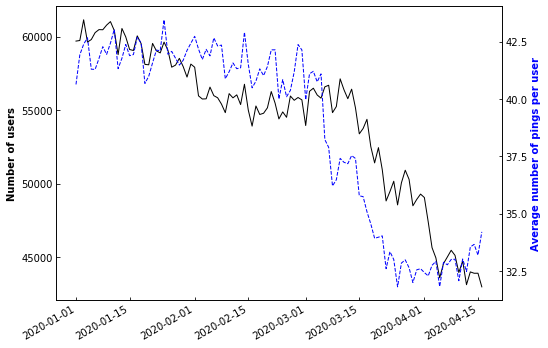

In [161]:
print('Figure')

fig,ax1=plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()

data1=n_pings_users_date['cuebiq_id'].truncate(after=end_date)
ax1.plot(data1.index,data1.values,linewidth=1,color='black')
data2=n_pings_users_date['n_pings'].divide(n_pings_users_date['cuebiq_id']).truncate(after=end_date)
ax2.plot(data2.index,data2.values,linewidth=1,color='b',linestyle='dashed')

ax1.tick_params(which='both',direction='in',pad=3)
ax2.tick_params(which='both',direction='in',pad=3)
ax1.locator_params(axis='y',nbins=6)
ax2.locator_params(axis='y',nbins=6)

ax1.set_xlabel('')
ax1.set_ylabel('Number of users',fontweight='bold',color='black')
ax2.set_ylabel('Average number of pings per user',fontweight='bold',color='b')
fig.autofmt_xdate()

plt.savefig(os.path.join(path_to_data+'/../fig',country,'activity-per-day.png'),bbox_inches='tight')

# Load results

In [3]:
print('Load')
start = timer()
duration_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_date_id.csv'),index_col=0)
duration_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_daytime_id.csv'),index_col=0)
duration_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'duration_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load


/scratch/spf248/pyenv/py3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done in 20 sec


In [4]:
print('Load')
start = timer()
distances_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_date_id.csv'),index_col=0)
distances_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_daytime_id.csv'),index_col=0)
distances_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'distances_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 21 sec


In [5]:
print('Load')
start = timer()
n_admin_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_date_id.csv'),index_col=0)
n_admin_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_daytime_id.csv'),index_col=0)
n_admin_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'n_admin_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 17 sec


In [99]:
print('Load')
start = timer()
entropy_date_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_date_id.csv'),index_col=0)
entropy_daytime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_daytime_id.csv'),index_col=0)
entropy_nighttime_id=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'entropy_nighttime_id.csv'),index_col=0)
print("Done in", round(timer()-start), "sec")

Load
Done in 17 sec


# Users activity

In [155]:
def users_activity(dfs,col1,col2,y_label,agg):
    fig,ax=plt.subplots(figsize=(8,6))
    for i,(df,label) in enumerate(zip(dfs,['Daytime','All day','Nighttime'])):
        data=df[df[col2]>min_pings].groupby('date')[col1].agg(['mean','sem'])
        color=sns.color_palette("coolwarm", 3)[2-i]
        data['mean'].plot(ax=ax,linewidth=1,color=color,label=label)
        plt.fill_between(data.index, data['mean']-2*data['sem'], data['mean']+2*data['sem'],alpha=0.25,color=color)
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=8)
    ax.set_xlabel('')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.legend(loc='best')
    fig.autofmt_xdate()
    print(y_label.replace(' ','-').lower())
    plt.savefig(os.path.join(path_to_data+'/../fig',country,y_label.replace(' ','-').lower()+'.png'),bbox_inches='tight')

share-of-users'-time-spent-at-home
share-of-users'-activity-in-unique-neighborhoods
max.-distance-between-users'-point-of-activity
entropy-of-users'-visits-of-neighborhoods


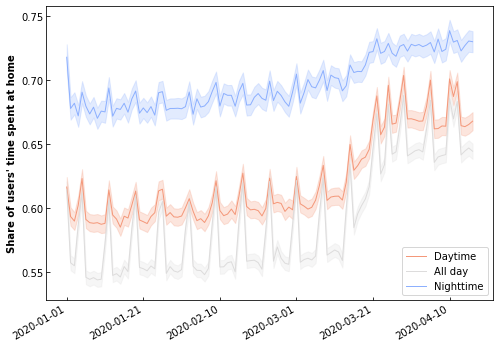

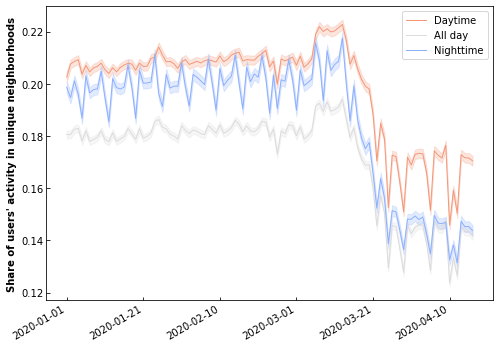

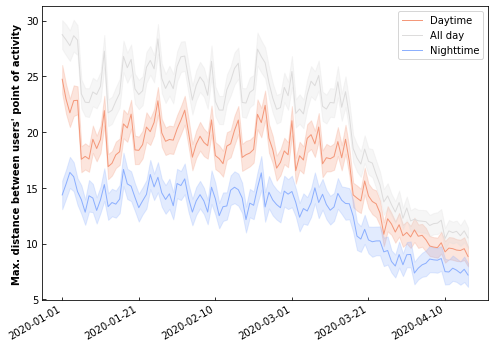

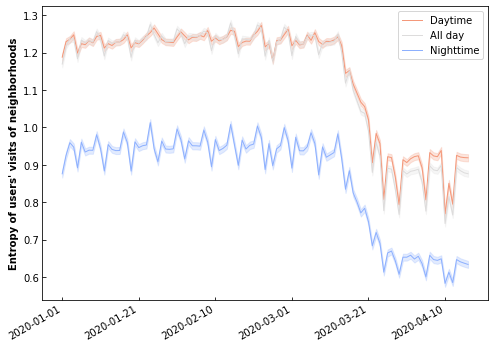

In [156]:
for (df_date,df_daytime,df_nighttime,col1,col2,agg,y_label) in zip(
[duration_date_id,n_admin_date_id,distances_date_id,entropy_date_id],
[duration_daytime_id,n_admin_daytime_id,distances_daytime_id,entropy_daytime_id],
[duration_nighttime_id,n_admin_nighttime_id,distances_nighttime_id,entropy_nighttime_id],
['pct_t','pct_unique','max_distance','entropy'],
['n_home','n_pings','n_pings','n_pings'],
['mean','mean','mean','mean'],
[
'Share of users\' time spent at home',
'Share of users\' activity in unique neighborhoods',
'Max. distance between users\' point of activity',
'Entropy of users\' visits of neighborhoods',
],
):
    dfs=[df_daytime,df_date,df_nighttime]
    users_activity(dfs,col1,col2,y_label,agg)

# Demographics

In [49]:
print('Import')
start = timer()
data_dir = Path(os.path.join(path_to_data,source,'processed',country,'primary_home'))
primary_home = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")  

Import
Done in 8 sec


In [50]:
print('Import')
start = timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Import
Done in 66 sec


In [51]:
def get_coords(df):
    df['latitude']=df['point'].apply(lambda x:x['latitude'])
    df['longitude']=df['point'].apply(lambda x:x['longitude'])
    return df.drop('point',1)

In [70]:
print('Merge admin and home data')
start = timer()
primary_home=get_coords(primary_home)
primary_home=gpd.GeoDataFrame(primary_home,geometry=gpd.points_from_xy(primary_home.longitude,primary_home.latitude))
primary_home.crs='epsg:4326'
geocoded_home=gpd.sjoin(primary_home[['cuebiq_id','geometry']],admin,op='intersects')
geocoded_home=geocoded_home.merge(admin2city,on=admin_id,how='left')
for col in demographics:
    print(col)
    geocoded_home[col+'_quantile']=pd.qcut(geocoded_home[col],2,range(1,3))
print("Done in", round(timer()-start), "sec")  

Merge admin and home data
wealth_index
median_age
Done in 0 sec


In [153]:
def activity_by_demographics(df_date,df_date_demog,col1,col2,col3,y_label,values,names):
    fig,ax=plt.subplots(figsize=(8,6))
    data=df_date[df_date[col2]>min_pings].groupby('date')[col1].agg(['mean','sem'])
    data['mean'].plot(ax=ax,linewidth=1,color='k',label='All users')
    plt.fill_between(data.index, data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.25,color='k')
    for i,(val,name) in enumerate(zip(values,names)):
        if col3==city_id:
            color=sns.color_palette("hls", len(geocoded_home.UC_NM_MN.value_counts().index[:3]))[i]
        else:
            color=sns.color_palette("coolwarm", 2)[i]
        data=df_date_demog[(df_date_demog[col2]>=min_pings)].groupby([col3,'date'])[col1].agg(['mean','sem']).loc[val]
        data['mean'].plot(ax=ax,linewidth=1,color=color,label=name)
        plt.fill_between(data.index,data['mean']-2*data['sem'],data['mean']+2*data['sem'],alpha=0.25,color=color)
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=6)
    ax.set_xlabel('')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.legend(loc='best')
    fig.autofmt_xdate()
    print(y_label.replace(' ','-').lower()+'-by-'+col3.replace('_','-'))
    plt.savefig(os.path.join(path_to_data+'/../fig',country,y_label.replace(' ','-').lower()+'-by-'+col3.replace('_','-')+'.png'),bbox_inches='tight')

share-of-users'-time-spent-at-home-by-median-age-quantile
share-of-users'-time-spent-at-home-by-wealth-index-quantile
share-of-users'-time-spent-at-home-by-UC-NM-MN
share-of-users'-activity-in-unique-neighborhoods-by-median-age-quantile
share-of-users'-activity-in-unique-neighborhoods-by-wealth-index-quantile
share-of-users'-activity-in-unique-neighborhoods-by-UC-NM-MN
max.-distance-between-users'-point-of-activity-by-median-age-quantile
max.-distance-between-users'-point-of-activity-by-wealth-index-quantile
max.-distance-between-users'-point-of-activity-by-UC-NM-MN
entropy-of-users'-visits-of-neighborhoods-by-median-age-quantile
entropy-of-users'-visits-of-neighborhoods-by-wealth-index-quantile
entropy-of-users'-visits-of-neighborhoods-by-UC-NM-MN


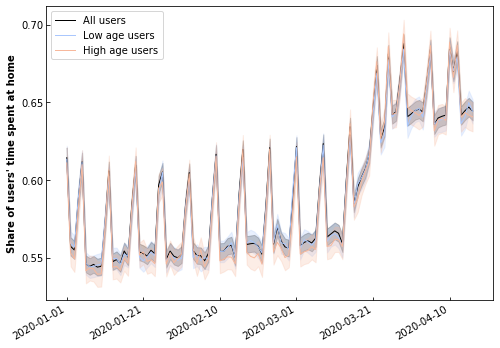

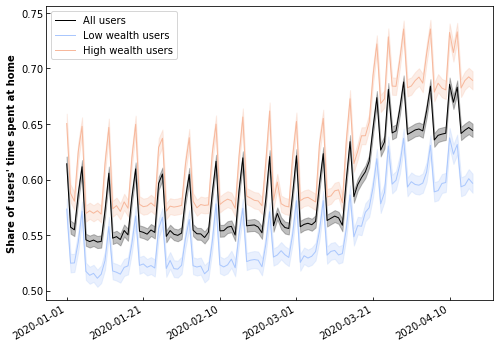

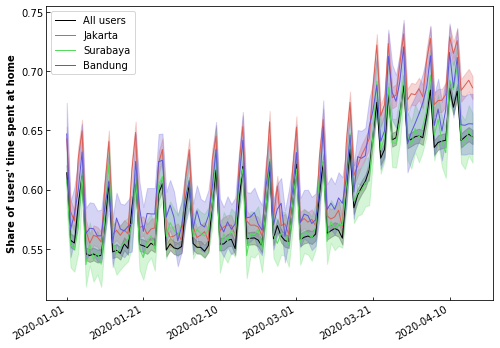

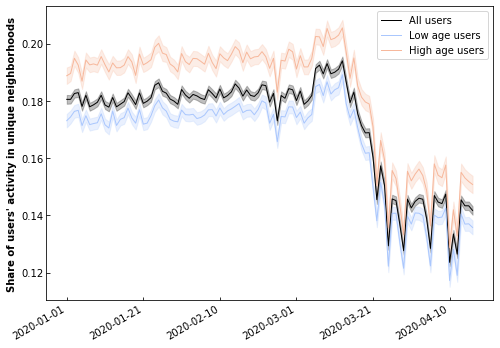

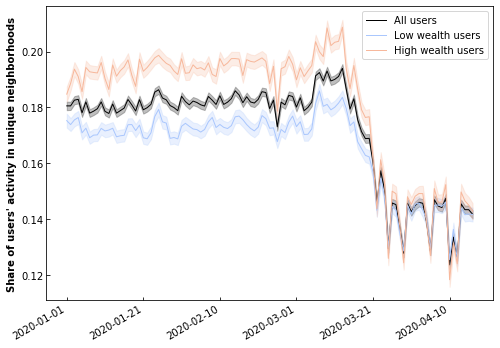

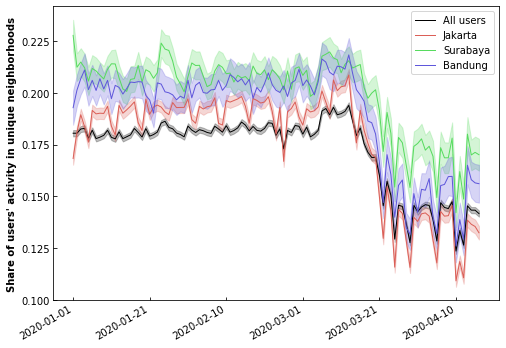

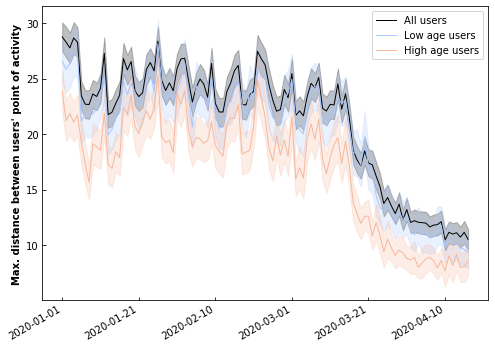

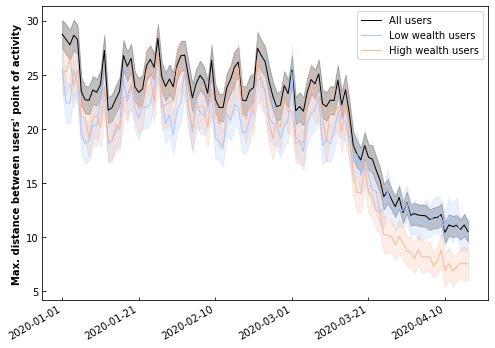

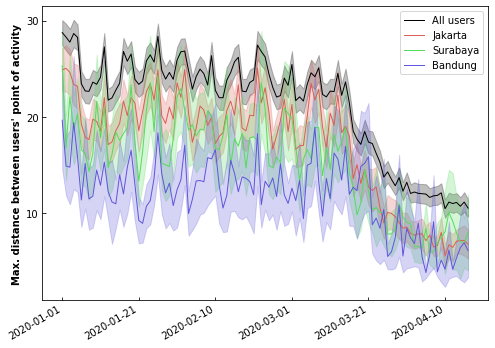

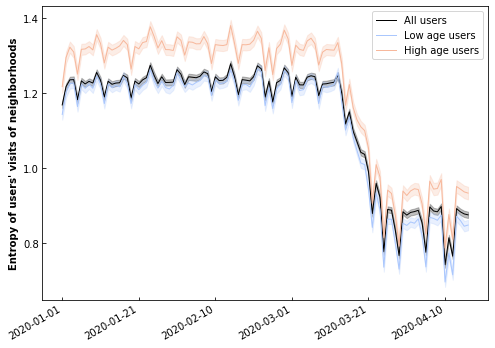

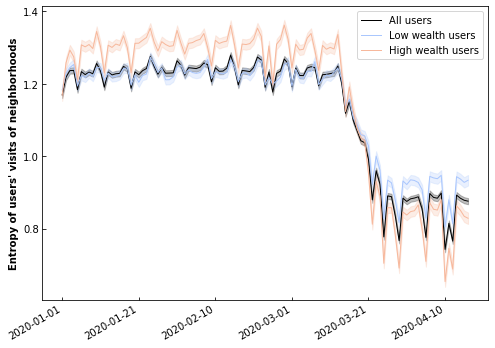

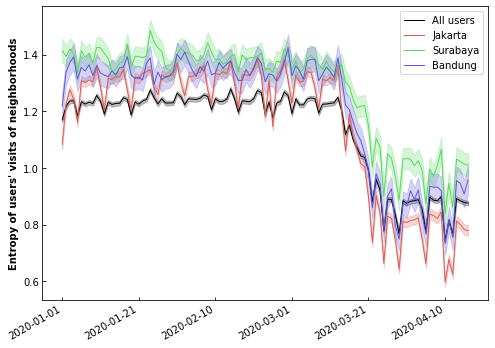

In [154]:
for (df_date,col1,col2,y_label) in zip(
[duration_date_id,n_admin_date_id,distances_date_id,entropy_date_id],
['pct_t','pct_unique','max_distance','entropy'],
['n_home','n_pings','n_pings','n_pings'],
[
'Share of users\' time spent at home',
'Share of users\' activity in unique neighborhoods',
'Max. distance between users\' point of activity',
'Entropy of users\' visits of neighborhoods',
],
):
    df_date_demog=df_date.merge(geocoded_home,on='cuebiq_id')
    for (col3,values,names) in zip(
    ['median_age_quantile',
     'wealth_index_quantile',
     city_id],
    [[1,2],
     [1,2],
     geocoded_home.UC_NM_MN.value_counts().index[:3]],
    [['Low age users','High age users'],
     ['Low wealth users','High wealth users'],
     geocoded_home.UC_NM_MN.value_counts().index[:3]]):
        activity_by_demographics(df_date,df_date_demog,col1,col2,col3,y_label,values,names)